# Reviews EDA (Corrected Parsing)
- **Objective**: `user_id` 대량 누락 문제를 해결하기 위해 원본 JSON 파싱 로직을 개선합니다.
- **Method**: 원본 JSON의 중첩 구조(`Nested Structure`)를 확인하고, 올바르게 파싱하여 Parquet를 재생성합니다.
- **Tool**: `polars`를 사용하여 고속으로 처리합니다.

In [51]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import ast
import json

# 파일 경로 설정
RAW_DATA_PATH = '../../steam_data/now_steam/steam_new.json'
REVIEWS_PARQUET_PATH = '../../steam_data/now_steam/reviews.parquet'
ITEMS_PARQUET_PATH = '../../steam_data/now_steam/australian_users_items.parquet'

print("🚀 Polars Version:", pl.__version__)

🚀 Polars Version: 1.37.0


# 1. 원본 데이터 구조 진단 (Raw Data Inspection)
- 파일의 처음 5줄을 읽어 실제 JSON 구조를 눈으로 확인합니다.
- `user_id`가 1차원 키인지, `author` 같은 객체 안에 숨어있는지(`Nested`) 파악합니다.

In [52]:
print(f"🔍 Inspecting: {RAW_DATA_PATH}")

try:
    with open(RAW_DATA_PATH, 'r', encoding='utf-8') as f:
        for i in range(5):
            line = f.readline()
            if not line: break
            
            # `ast.literal_eval`은 Python Syntax의 Dict 문자열("Single Quote" 등)을 파싱할 때 유리
            # `json.loads`는 표준 JSON("Double Quote")일 때 유리
            # 여기서는 안전하게 둘 다 고려하거나 ast를 사용 (기존 코드가 ast 사용)
            try:
                data = ast.literal_eval(line.strip())
                print(f"\n[Line {i+1}] Keys: {list(data.keys())}")
                
                # 1. user_id 직접 확인
                u_id = data.get('user_id')
                print(f"   - user_id: {u_id} (Type: {type(u_id)})")
                
                # 2. Nested 구조(author 등) 확인
                if 'author' in data:
                    print(f"   - author keys: {list(data['author'].keys())}")
                    print(f"   - author.steamid: {data['author'].get('steamid')}")
                    
            except Exception as e:
                print(f"[Line {i+1}] Parse Error: {e}")
                print(f"Raw Content: {line[:100]}...")
except FileNotFoundError:
    print("❌ 원본 파일을 찾을 수 없습니다.")

🔍 Inspecting: ../../steam_data/now_steam/steam_new.json

[Line 1] Keys: ['username', 'hours', 'products', 'product_id', 'page_order', 'date', 'text', 'early_access', 'page']
   - user_id: None (Type: <class 'NoneType'>)

[Line 2] Keys: ['username', 'hours', 'products', 'product_id', 'page_order', 'date', 'text', 'early_access', 'page']
   - user_id: None (Type: <class 'NoneType'>)

[Line 3] Keys: ['username', 'text', 'hours', 'date', 'early_access', 'found_funny', 'product_id', 'page_order', 'compensation', 'products', 'page']
   - user_id: None (Type: <class 'NoneType'>)

[Line 4] Keys: ['username', 'hours', 'products', 'product_id', 'page_order', 'date', 'text', 'early_access', 'page']
   - user_id: None (Type: <class 'NoneType'>)

[Line 5] Keys: ['username', 'text', 'hours', 'date', 'early_access', 'user_id', 'product_id', 'page_order', 'products', 'page']
   - user_id: 76561198007483075 (Type: <class 'str'>)


# 2. 데이터 재생성 (Robust Conversion)
- 위에서 확인한 구조를 바탕으로, `user_id`를 놓치지 않는 강력한 파싱 로직을 적용합니다.
- Python Loop로 파싱 후 Polars DataFrame으로 변환하여 Parquet로 저장합니다.

In [53]:
import pyarrow as pa
import pyarrow.parquet as pq

def extract_user_id(data):
    # 1순위: user_id 키 직접 확인
    if 'user_id' in data and data['user_id']:
        return str(data['user_id'])
    
    # 2순위: username
    if 'username' in data and data['username']:
        return str(data['username'])
        
    # 3순위: author 객체 내부의 steamid
    if 'author' in data and isinstance(data['author'], dict):
        if 'steamid' in data['author']:
            return str(data['author']['steamid'])
            
    return "" # 못 찾음

def convert_and_save(input_path, output_path, chunk_size=500000):
    if os.path.exists(output_path):
        print("⚠️ 기존 Parquet 파일이 존재합니다. 덮어씁니다.")
    
    print(f"🚀 변환 시작... (Chunk Size: {chunk_size:,})")
    
    chunk_buffer = []
    processed_count = 0
    writer = None
    
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data = ast.literal_eval(line.strip())
                
                # 💡 Improved Extraction Logic
                u_id = extract_user_id(data)
                
                record = {
                    'user_id': u_id,
                    'product_id': str(data.get('product_id', '')),
                    'review': str(data.get('text', '')),
                    'hours': float(data.get('hours', 0.0)),
                    'date': str(data.get('date', ''))
                }
                
                chunk_buffer.append(record)
                
                if len(chunk_buffer) >= chunk_size:
                    # Polars로 변환 후 PyArrow로 저장 (Chunk 단위)
                    df_chunk = pl.DataFrame(chunk_buffer)
                    table = df_chunk.to_arrow()
                    
                    if writer is None:
                        writer = pq.ParquetWriter(output_path, table.schema, compression='snappy')
                    
                    writer.write_table(table)
                    processed_count += len(chunk_buffer)
                    chunk_buffer = []
                    print(f"... Processed {processed_count:,} rows")
                    
            except Exception as e:
                continue
                
        # 나머지 저장
        if chunk_buffer:
            df_chunk = pl.DataFrame(chunk_buffer)
            table = df_chunk.to_arrow()
            if writer is None:
                writer = pq.ParquetWriter(output_path, table.schema, compression='snappy')
            writer.write_table(table)
            processed_count += len(chunk_buffer)
            
        if writer:
            writer.close()
            
    print(f"✅ 완료! 총 {processed_count:,} 행 저장됨.")

# 실행 (한 번 실행 후 주석 처리 가능)
# convert_and_save(RAW_DATA_PATH, REVIEWS_PARQUET_PATH) # Skip regeneration if already done

# 3. 데이터 품질 재확인 (Re-Check)
- 재생성된 Parquet 파일을 로드하여 `user_id` 결측치 비율이 개선되었는지 확인합니다.

In [54]:
if os.path.exists(REVIEWS_PARQUET_PATH):
    reviews_pl = pl.read_parquet(REVIEWS_PARQUET_PATH)
    total_rows = reviews_pl.height
    
    # 결측치 확인
    null_count = reviews_pl['user_id'].null_count()
    empty_count = reviews_pl.filter(pl.col('user_id') == '').height
    
    print(f"📊 [New Data Quality Report]")
    print(f"Total Rows: {total_rows:,}")
    print(f"Null user_id: {null_count:,} ({null_count/total_rows*100:.2f}%)")
    print(f"Empty user_id ('') : {empty_count:,} ({empty_count/total_rows*100:.2f}%)")
    
    if empty_count == 0:
        print("🎉 Success! 모든 빈 ID가 복구되었습니다.")
    else:
        print("⚠️ 여전히 빈 ID가 존재합니다. 원본 데이터를 더 깊게 파봐야 합니다.")
else:
    print("❌ 파일 생성 실패")

📊 [New Data Quality Report]
Total Rows: 7,793,069
Null user_id: 0 (0.00%)
Empty user_id ('') : 0 (0.00%)
🎉 Success! 모든 빈 ID가 복구되었습니다.


# 4. EDA 재진행 (Clean Data)
- 정제된 데이터를 바탕으로 리뷰 분포 및 관계 분석을 다시 수행합니다.


[Review Count Stats]
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 2.827199e6 │
│ null_count ┆ 0.0        │
│ mean       ┆ 2.756463   │
│ std        ┆ 6.992568   │
│ min        ┆ 1.0        │
│ 25%        ┆ 1.0        │
│ 50%        ┆ 1.0        │
│ 75%        ┆ 3.0        │
│ max        ┆ 1254.0     │
└────────────┴────────────┘

[Quantiles]
shape: (1, 4)
┌──────┬──────┬───────┬────────┐
│ p0.5 ┆ p0.9 ┆ p0.99 ┆ p0.999 │
│ ---  ┆ ---  ┆ ---   ┆ ---    │
│ f64  ┆ f64  ┆ f64   ┆ f64    │
╞══════╪══════╪═══════╪════════╡
│ 1.0  ┆ 5.0  ┆ 22.0  ┆ 78.0   │
└──────┴──────┴───────┴────────┘

[Top 5 Heavy Users]
shape: (5, 2)
┌───────────────────┬──────────────┐
│ user_id           ┆ review_count │
│ ---               ┆ ---          │
│ str               ┆ u32          │
╞═══════════════════╪══════════════╡
│ 76561198011965365 ┆ 1254         │
│ Kodyd194          ┆ 1129   

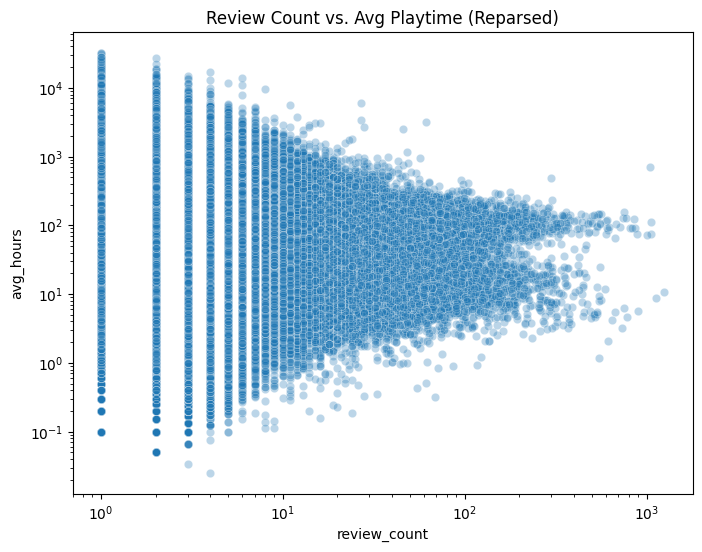

In [55]:
# 유효 데이터 필터링 (혹시 모를 잔여물 제거)
clean_reviews_pl = reviews_pl.filter(
    (pl.col('user_id').is_not_null()) &
    (pl.col('user_id') != '')
)

# 1. 리뷰 수 통계
user_counts_pl = clean_reviews_pl.group_by('user_id').len().rename({'len': 'review_count'})
print("\n[Review Count Stats]")
print(user_counts_pl['review_count'].describe())

# 2. 분위수 확인
q_list = [0.5, 0.9, 0.99, 0.999]
quantiles = user_counts_pl.select([
    pl.col('review_count').quantile(q).alias(f'p{q}') for q in q_list
])
print("\n[Quantiles]")
print(quantiles)

# 3. Top 헤비 유저 (Outlier Check)
print("\n[Top 5 Heavy Users]")
print(user_counts_pl.sort('review_count', descending=True).head(5))

# 4. 플레이 타임 관계 시각화
user_stats_pl = clean_reviews_pl.group_by('user_id').agg([
    pl.len().alias('review_count'),
    pl.col('hours').mean().alias('avg_hours')
])
user_stats_pd = user_stats_pl.to_pandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=user_stats_pd, x='review_count', y='avg_hours', alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.title('Review Count vs. Avg Playtime (Reparsed)')
plt.show()

## 4.4 인기 게임 Top 20 시각화 (Game Popularity)
- 리뷰 수가 가장 많은 상위 20개 게임을 시각화합니다.
- 텍스트 리스트 대신 **Bar Chart**를 사용하여 직관적으로 비교합니다.

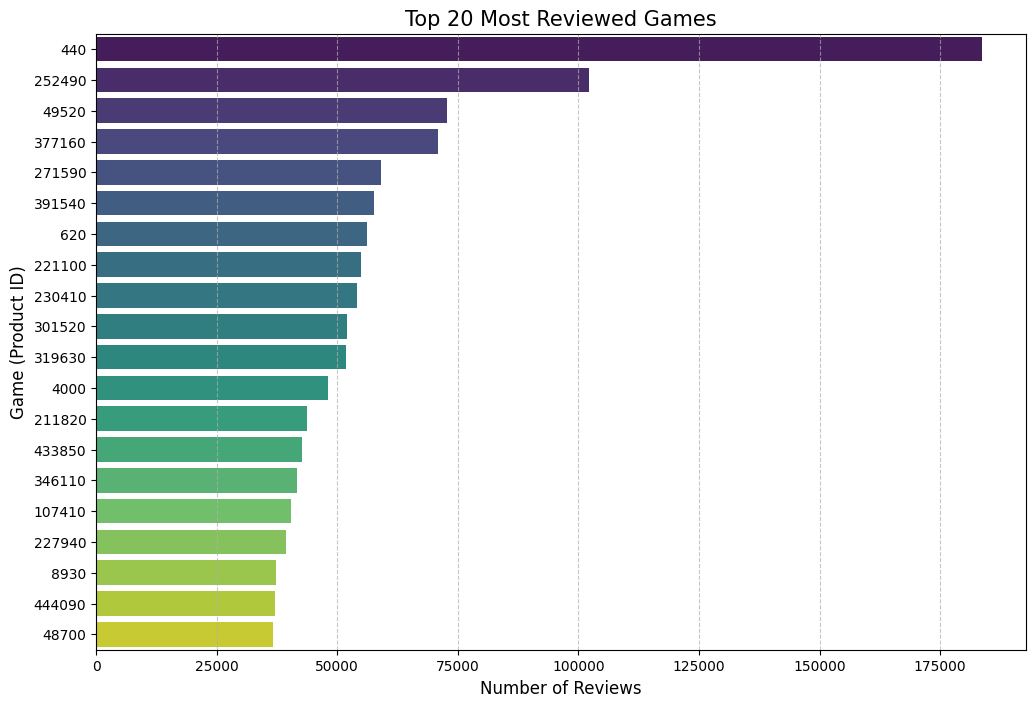

In [56]:
# 1. 게임별 리뷰 수 집계
game_counts_pl = clean_reviews_pl.group_by('product_id').len().rename({'len': 'review_count'})

# 2. Top 20 추출
top_20_games = game_counts_pl.sort('review_count', descending=True).head(20)

# 3. Pandas 변환 (시각화용)
top_20_pd = top_20_games.to_pandas()

# 4. 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=top_20_pd, x='review_count', y='product_id', palette='viridis', hue='product_id', legend=False)
plt.title('Top 20 Most Reviewed Games', fontsize=15)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Game (Product ID)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()